***IDS Assignment Group 029 : Assignment 1 - Problem 9 : Q1 - Vision Dataset: imagenette/160px-v2- Imagenette - Sequential Neural Network Implementation***      
Group Members : AMITABH GUPTA: 2019AB04170;  DEBORIMA SENAPATI : 2019ab04184; PRIYADARSHI MISHRA : 2019ab04133


###**1.Import Libraries/Dataset**

##### a. -----Import the required libraries and the dataset (use Google Drive if required)-----.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from plot_conf_matr import plot_confusion_matrix
import seaborn as sn
import pandas  as pd
import time

import matplotlib.pyplot as plt

In [4]:
(Imagenet_G29_train,Imagenet_G29_test), info = tfds.load('imagenette/160px-v2', split=['train','validation'],as_supervised=True, shuffle_files=True, with_info=True)

##### -------b. Check the GPU available (recommended-use free GPU provided by Google Colab).-------

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### **2.Data Visualizationand augmentation(1mark)**

#### 2a.------Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library)--------.

In [6]:
print("Output_Classes_No: " + str(info.features['label'].num_classes))
print("Output_Classes: " + str(info.features['label'].names))
class_names=info.features['label'].names
num_classes = info.features['label'].num_classes
X_test = list(map(lambda x: x[0], Imagenet_G29_test))
Y_test = list(map(lambda x: x[1], Imagenet_G29_test))
Ytest = list(map(lambda x: x[1], Imagenet_G29_test))
Ytest = tf.keras.utils.to_categorical(Ytest, num_classes)
Ytest = np.array(Ytest)
print(Ytest.shape)

Output_Classes_No: 10
Output_Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
(3925, 10)


In [7]:
data_visual = Imagenet_G29_train.take(0)
for name in info.features['label'].names:
  data_visual=data_visual.concatenate(Imagenet_G29_train.take(50).filter(lambda image, label: label == info.features["label"].str2int(name)).take(2))

In [8]:
Imagenet_Frame = tfds.as_dataframe(Imagenet_G29_train.take(50),info)

In [9]:
Imagenet_Frame_2 = Imagenet_Frame.groupby('label', as_index=False).head(2)

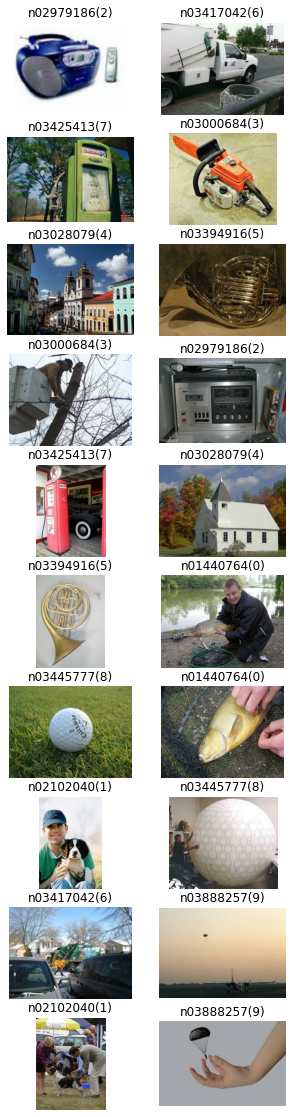

In [10]:
plt.figure(figsize=(5, 20))
i=1
for idx,row in Imagenet_Frame_2.iterrows():
  ax = plt.subplot(10, 2, i)
  plt.imshow(row['image'].astype("uint8"))
  plt.title(class_names[row['label']]+"({})".format(row['label']))
  plt.axis("off")
  i=i+1


In [11]:
# tfds.visualization.show_examples(data_visual, info, rows=10, cols=2)

**Data Augmentation**

#### 2b. ........Apply rotation and height shift augmentation (horizontal_flip, width_shift_range)to the dataset separately. Print the augmented image and the original image for each class and each augmentation.......

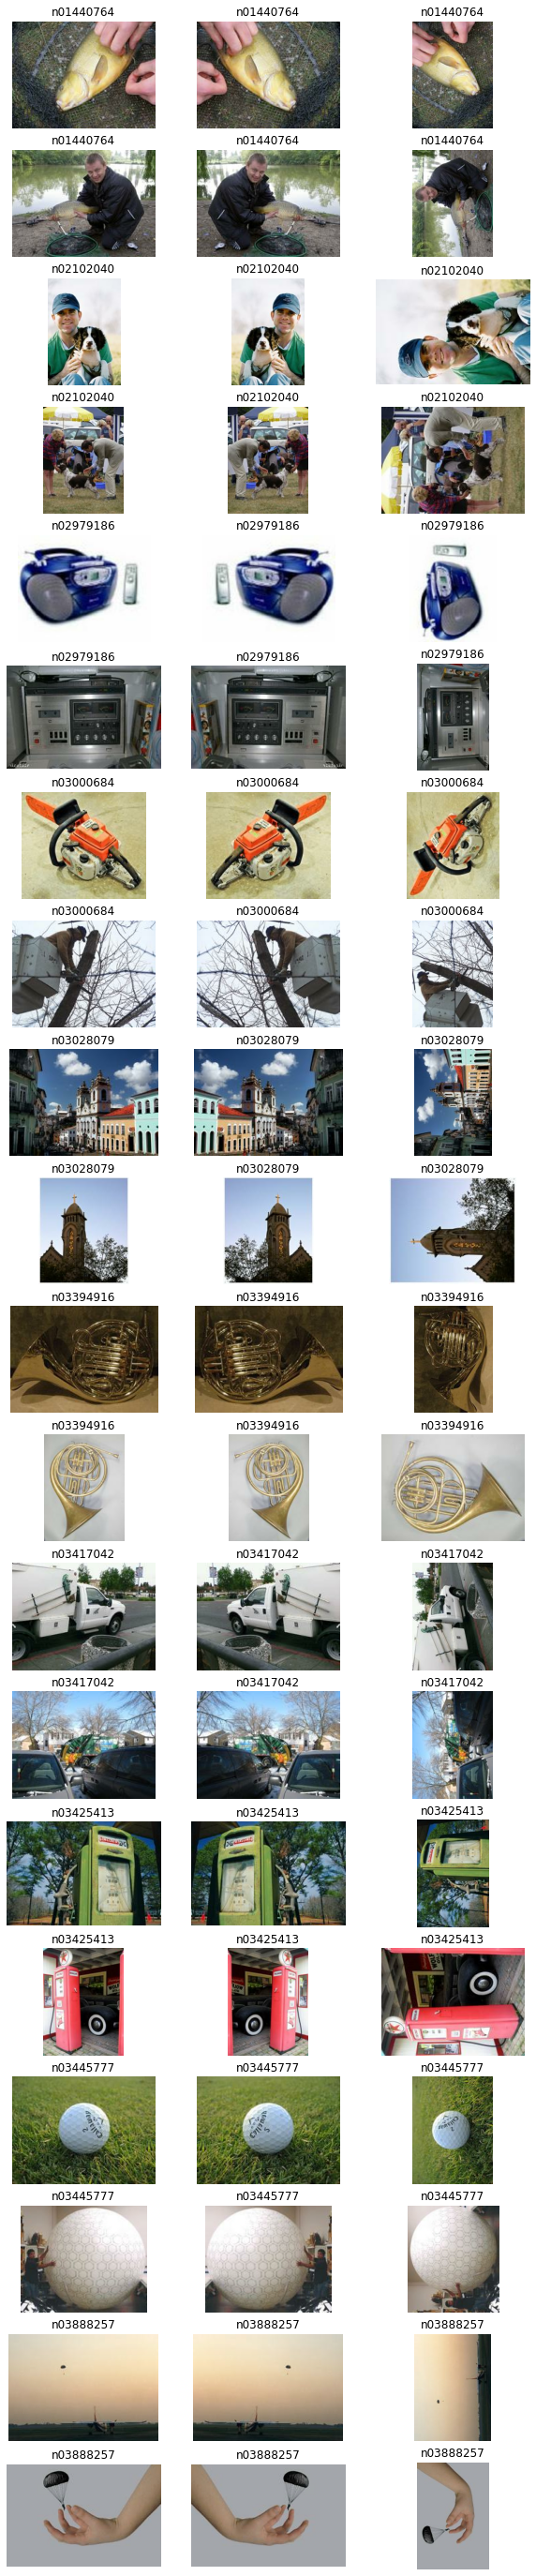

In [12]:
class_names = info.features['label'].names
plt.figure(figsize=(10, 50))
i=1
for example, label in data_visual:
  ax = plt.subplot(20, 3, i)
  plt.imshow(example.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis("off")

  aug_img = tf.image.flip_left_right(example)
  ax = plt.subplot(20, 3, i+1)
  plt.imshow(aug_img)
  plt.title(class_names[label])
  plt.axis("off")

  aug_img = tf.image.rot90(example)
  ax = plt.subplot(20, 3, i+2)
  plt.imshow(aug_img)
  plt.title(class_names[label])
  plt.axis("off")

  i=i+3

#### **......c.Bring the train and test data in the required format.......**

#### **------d.Print the shapes of train and test data.......**

In [13]:
Imagenet_G29_train
tf.data.experimental.cardinality(Imagenet_G29_train).numpy()

9469

In [14]:
info.features['image'].shape

(None, None, 3)

In [15]:
for image, label in Imagenet_G29_train.take(1):
    print("Image shape for train data: ", image.numpy().shape)

Image shape for train data:  (160, 213, 3)


In [16]:
for image, label in Imagenet_G29_test.take(1):
    print("Image shape for test data: ", image.numpy().shape)

Image shape for test data:  (160, 189, 3)


In [17]:
info.splits['train'].num_examples, info.splits['validation'].num_examples

(9469, 3925)

In [18]:
IMG_SIZE = 128

def processing_img(img, lbl, img_shape=IMG_SIZE):
  img = tf.image.resize(img,[img_shape, img_shape])
  return tf.cast(img,tf.float32)/255.,lbl

def normalize_img(image, label):
  img = tf.image.resize(image,[IMG_SIZE, IMG_SIZE])
  return tf.cast(image,tf.float32)/255.,label

Imagenet_G29_train = Imagenet_G29_train.map(
    processing_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Imagenet_G29_train = Imagenet_G29_train.cache()
Imagenet_G29_train = Imagenet_G29_train.shuffle(info.splits['train'].num_examples)
Imagenet_G29_train = Imagenet_G29_train.batch(16)
Imagenet_G29_train = Imagenet_G29_train.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
Imagenet_G29_test = Imagenet_G29_test.map(
    processing_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
Imagenet_G29_test = Imagenet_G29_test.batch(16)
Imagenet_G29_test = Imagenet_G29_test.cache()
Imagenet_G29_test = Imagenet_G29_test.prefetch(tf.data.experimental.AUTOTUNE)

### **3.Model Building**

> 3a.----Sequential Model layers-Use AT LEAST 3 hiddenlayers with appropriate inputfor each. Choose the best number for hidden units and give reasons----

> 3b.----Add L2 regularization to all the layers----

> 3c.----Add one layer of dropout at the appropriate position and give reasons---

> 3d.----Choose the appropriate activation function for all the layers.----

> 3e.-----Print the model summary--------



In [20]:
def augment(image, label):
  image= tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.random_flip_left_right(image)
  image= tf.image.random_flip_up_down(image)
  image = tf.image.rot90(image)
  return image,label
Imagenet_G29_train.concatenate(Imagenet_G29_train.map(augment))

<ConcatenateDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>

In [21]:
model = tf.keras.models.Sequential([   
  # data_augmentation,                             
  tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
  tf.keras.layers.Dense(512,activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001)),
  # tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(512,activation='relu', bias_regularizer=tf.keras.regularizers.L2(0.001)),
  # tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(512,activation='relu', bias_regularizer=tf.keras.regularizers.L2(0.001)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(10,activation="softmax")
])

In [22]:
# model = tf.keras.models.Sequential([   
#   # data_augmentation,                             
#   tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
#   tf.keras.layers.Dense(512,activation='relu'),
#   # tf.keras.layers.Dropout(.2),
#   tf.keras.layers.Dense(512,activation='relu'),
#   # tf.keras.layers.Dropout(.2),
#   tf.keras.layers.Dense(512,activation='relu'),
#   # tf.keras.layers.Dropout(.2),
#   tf.keras.layers.Dense(10,activation="softmax")
# ])

In [23]:
model.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25166336  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 25,696,778
Trainable params: 25,696,778
Non-trainable params: 0
____________________________________________

### 4.Model Compilation(0.25 mark)
>a.Compile the model with the appropriate loss function.

>b.Use an appropriate optimizer.Give reasonsfor the choice of learning rateand its value.

>c.Use accuracy as metric.

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### 5.Model Training
> a.Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

>b.Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [25]:
import time
t = time.time()
epochs=20
history=model.fit(
    Imagenet_G29_train,
    epochs=epochs,
    batch_size=16,
    validation_data=Imagenet_G29_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/20
592/592 [==============================] - 12s 11ms/step - loss: 5.2082 - accuracy: 0.1346 - val_loss: 2.2570 - val_accuracy: 0.1549
Epoch 2/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2777 - accuracy: 0.1304 - val_loss: 2.2328 - val_accuracy: 0.1480
Epoch 3/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2450 - accuracy: 0.1485 - val_loss: 2.2684 - val_accuracy: 0.1315
Epoch 4/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2319 - accuracy: 0.1536 - val_loss: 2.2404 - val_accuracy: 0.1562
Epoch 5/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2068 - accuracy: 0.1642 - val_loss: 2.2174 - val_accuracy: 0.1534
Epoch 6/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2190 - accuracy: 0.1669 - val_loss: 2.2330 - val_accuracy: 0.1758
Epoch 7/20
592/592 [==============================] - 5s 9ms/step - loss: 2.2238 - accuracy: 0.1648 - val_loss: 2.1919 - val_accuracy: 0.1615
Epoc

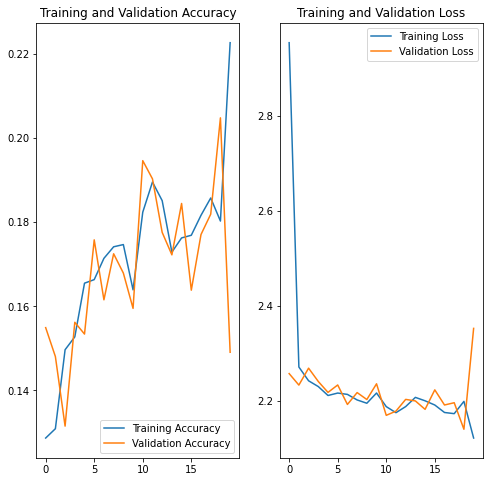

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[9 9 9 ... 9 4 6]
Print confusion matrix ------
[[ 28   2   4   0  79  42  57   0  19 156]
 [ 15   1  16   0  20  33  35   0   9 266]
 [  2   0   7   0  18  10  21   0   0 299]
 [  5   2  10   0  15  19  35   0   3 297]
 [  3   1   2   0  83  23  84   0   1 212]
 [  6   0   9   0  27  33  51   0   2 266]
 [  1   0   2   0   9   3  28   0   0 346]
 [  2   3   7   0  35  10  48   0   1 313]
 [ 18   0   3   0 108  15  47   0  64 144]
 [  1   0   0   0  21   1  24   0   2 341]]


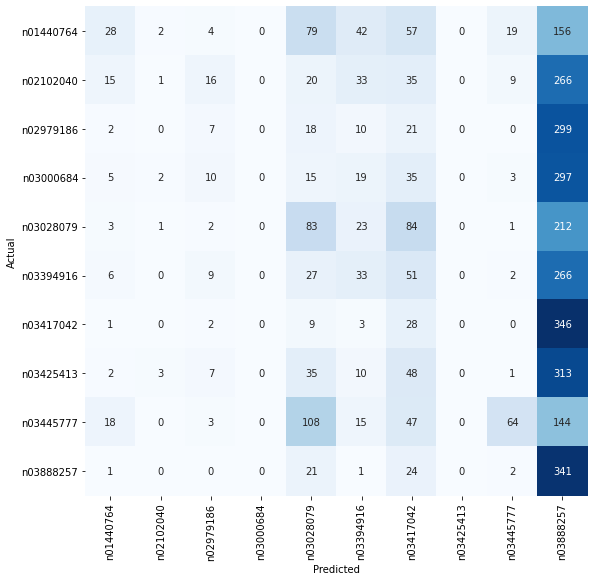

In [27]:
# Confusion matrix result
y_pred = model.predict(Imagenet_G29_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm = confusion_matrix(np.argmax(Ytest,axis=1),y_pred)

print("Print confusion matrix ------")
print(cm)

# Visualizing of confusion matrix
plt.figure(figsize=(9,9))
sn.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Print the two most incorrectly classified images for each class in the test dataset**

classification report -----
              precision    recall  f1-score   support

   n01440764       0.35      0.07      0.12       387
   n02102040       0.11      0.00      0.00       395
   n02979186       0.12      0.02      0.03       357
   n03000684       0.00      0.00      0.00       386
   n03028079       0.20      0.20      0.20       409
   n03394916       0.17      0.08      0.11       394
   n03417042       0.07      0.07      0.07       389
   n03425413       0.00      0.00      0.00       419
   n03445777       0.63      0.16      0.26       399
   n03888257       0.13      0.87      0.23       390

    accuracy                           0.15      3925
   macro avg       0.18      0.15      0.10      3925
weighted avg       0.18      0.15      0.10      3925

 Print the two most incorrectly classified images for each class in the test dataset.:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


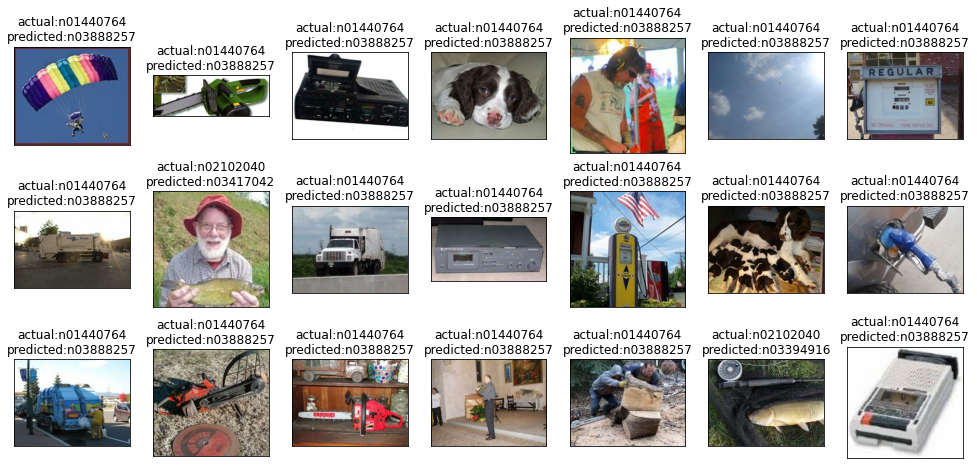

In [30]:
print("classification report -----")
print(classification_report(np.argmax(Ytest,axis=1),y_pred,target_names=class_names))

print(" Print the two most incorrectly classified images for each class in the test dataset.:")

y_test = Ytest.astype(int)
predictions = y_pred.astype(int)
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
    sharey=True, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title('actual:' + class_names[y_test[index][0]]+ '\n' 
                            + 'predicted:' + class_names[predictions[index]])
        axes[i,j].imshow(X_test[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

Hyperparameter Tuning - 1 : Dropout

In [31]:
model = tf.keras.models.Sequential([   
   # data_augmentation,                             
   tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(10,activation="softmax")
])

In [33]:
model.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               25166336  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 25,696,778
Trainable params: 25,696,778
Non-trainable params: 0
_________________________________________________________________


In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [35]:
import time
t = time.time()
epochs=20
history=model.fit(
    Imagenet_G29_train,
    epochs=epochs,
    batch_size=16,
    validation_data=Imagenet_G29_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/20
592/592 [==============================] - 6s 9ms/step - loss: 6.3068 - accuracy: 0.1801 - val_loss: 2.1307 - val_accuracy: 0.2385
Epoch 2/20
592/592 [==============================] - 5s 9ms/step - loss: 2.0499 - accuracy: 0.2700 - val_loss: 1.9690 - val_accuracy: 0.3070
Epoch 3/20
592/592 [==============================] - 5s 9ms/step - loss: 1.9499 - accuracy: 0.3103 - val_loss: 1.9113 - val_accuracy: 0.3287
Epoch 4/20
592/592 [==============================] - 5s 9ms/step - loss: 1.8954 - accuracy: 0.3261 - val_loss: 1.9294 - val_accuracy: 0.3167
Epoch 5/20
592/592 [==============================] - 5s 9ms/step - loss: 1.8550 - accuracy: 0.3548 - val_loss: 2.0146 - val_accuracy: 0.2940
Epoch 6/20
592/592 [==============================] - 5s 9ms/step - loss: 1.8127 - accuracy: 0.3715 - val_loss: 1.8535 - val_accuracy: 0.3582
Epoch 7/20
592/592 [==============================] - 5s 9ms/step - loss: 1.7976 - accuracy: 0.3731 - val_loss: 1.9655 - val_accuracy: 0.3080
Epoch 

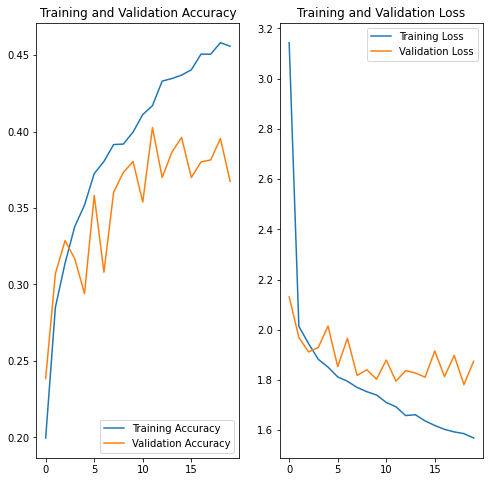

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Hyperparameter Tuning : Batch Size

In [37]:
model = tf.keras.models.Sequential([   
   # data_augmentation,                             
   tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
   tf.keras.layers.Dense(512,activation='relu'),
   # tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(10,activation="softmax")
])

In [38]:
model.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               25166336  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 25,696,778
Trainable params: 25,696,778
Non-trainable params: 0
_________________________________________________________________


In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [40]:
import time
t = time.time()
epochs=20
history=model.fit(
    Imagenet_G29_train,
    epochs=epochs,
    batch_size=100,
    validation_data=Imagenet_G29_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/20
592/592 [==============================] - 6s 9ms/step - loss: 5.9083 - accuracy: 0.1891 - val_loss: 2.4068 - val_accuracy: 0.1985
Epoch 2/20
592/592 [==============================] - 5s 9ms/step - loss: 2.0718 - accuracy: 0.2542 - val_loss: 2.1845 - val_accuracy: 0.1748
Epoch 3/20
592/592 [==============================] - 5s 9ms/step - loss: 2.1128 - accuracy: 0.2251 - val_loss: 2.0258 - val_accuracy: 0.2741
Epoch 4/20
592/592 [==============================] - 5s 9ms/step - loss: 2.0036 - accuracy: 0.2787 - val_loss: 1.8973 - val_accuracy: 0.3366
Epoch 5/20
592/592 [==============================] - 5s 9ms/step - loss: 1.9088 - accuracy: 0.3266 - val_loss: 2.1158 - val_accuracy: 0.2983
Epoch 6/20
592/592 [==============================] - 5s 9ms/step - loss: 1.9015 - accuracy: 0.3345 - val_loss: 1.9514 - val_accuracy: 0.3203
Epoch 7/20
592/592 [==============================] - 5s 9ms/step - loss: 1.8632 - accuracy: 0.3528 - val_loss: 1.8915 - val_accuracy: 0.3386
Epoch 

In [41]:
#import time
#t = time.time()
#epochs=20
#history=model.fit(
 #   Imagenet_G29_train,
  #  epochs=epochs,
   # batch_size=500,
    #validation_data=Imagenet_G29_test
#)
#print ("Total training time: ",time.time() - t)

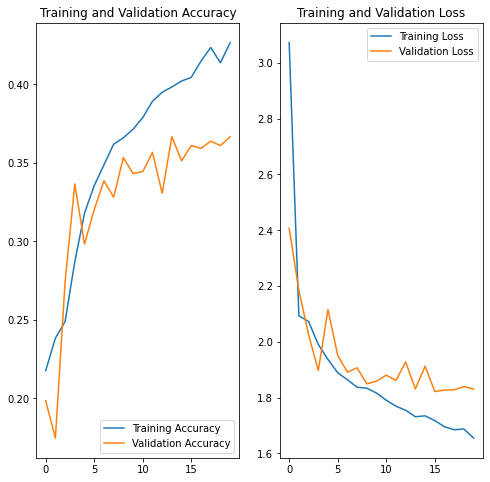

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
import time
t = time.time()
epochs=20
history=model.fit(
    Imagenet_G29_train,
    epochs=epochs,
    batch_size=500,
    validation_data=Imagenet_G29_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6381 - accuracy: 0.4339 - val_loss: 1.8609 - val_accuracy: 0.3646
Epoch 2/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6983 - accuracy: 0.4116 - val_loss: 1.9196 - val_accuracy: 0.3289
Epoch 3/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6465 - accuracy: 0.4334 - val_loss: 1.8338 - val_accuracy: 0.3615
Epoch 4/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6356 - accuracy: 0.4342 - val_loss: 1.8122 - val_accuracy: 0.3735
Epoch 5/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6060 - accuracy: 0.4423 - val_loss: 1.8663 - val_accuracy: 0.3613
Epoch 6/20
592/592 [==============================] - 5s 9ms/step - loss: 1.6160 - accuracy: 0.4381 - val_loss: 1.8695 - val_accuracy: 0.3587
Epoch 7/20
592/592 [==============================] - 5s 9ms/step - loss: 1.5923 - accuracy: 0.4514 - val_loss: 1.9333 - val_accuracy: 0.3457
Epoch 

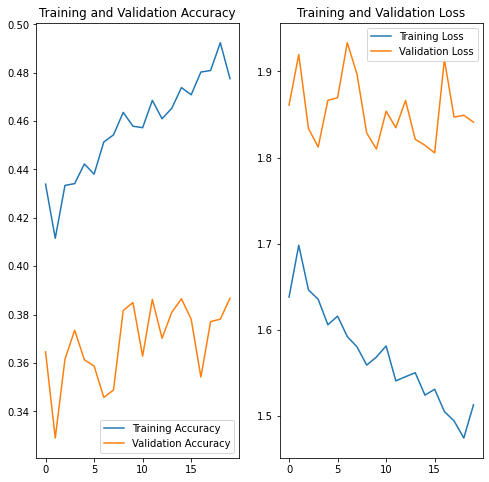

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**
Model accuracy significantly increased (30 > ~50%) by hyperparameter tuning :
Introducing dropout - provide more generalization for complex features & 
By increasing batch size - model got more features to learn in a every iteration to predict better. Further, this hyperparameter tuning reduce the model running time. 
Poorly classified classes have multiple features in a single image which are hard to classify by a sequential NN. By CNN we can predict these features & classify images with more accuracy. 
